#### Coding Discussion 6 
###### Lawand Yaseen 
###### November 21, 2021

In [ ]:
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree 
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

import sklearn.metrics as m

from sklearn.pipeline import Pipeline

In [41]:
#loading in separated training and test data 
test = pd.read_csv("/Users/lawandyaseen/Desktop/coding_discussions_ppol564_fall2021/06_coding_discussion/test_data.csv")
training = pd.read_csv("/Users/lawandyaseen/Desktop/coding_discussions_ppol564_fall2021/06_coding_discussion/train_data.csv")

#want to predict LN_Price

In [42]:
#Data Pre-Processing 

#list of column names in training data 
list(training)

#want include following variables: BEDRM, BATHRM, KITCHENS, LANDAREA, HEAT, ROOMS in model 

#dropping other variables 
training.drop(['OBJECTID','SSL','HF_BATHRM','HEAT','HEAT_D','AC','AYB','YR_RMDL','EYB','STORIES','SALEDATE','QUALIFIED',
 'SALE_NUM','GBA','BLDG_NUM','STYLE','STYLE_D','STRUCT','STRUCT_D','GRADE','GRADE_D','CNDTN','CNDTN_D','EXTWALL','EXTWALL_D',
 'ROOF','ROOF_D','INTWALL','INTWALL_D','FIREPLACES','USECODE','GIS_LAST_MOD_DTTM'], axis = 1, inplace = True)

#dropping houses with no price listed 
training = training[~training.LN_PRICE.isna()]

#dropping all rows with NA values (for predictor variables)
training.dropna(inplace = True)

training_y = training['LN_PRICE']
training_x = training[['BATHRM','NUM_UNITS','ROOMS','BEDRM','KITCHENS','LANDAREA']]

In [44]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['BATHRM','NUM_UNITS','ROOMS','BEDRM','KITCHENS','LANDAREA'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(training_x,training_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['BATHRM',
                                                                          'NUM_UNITS',
                                                                          'ROOMS',
                                                                          'BEDRM',
                                                                          'KITCHENS',
                                                                          'LANDAREA'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor(

In [45]:
search.best_score_  # Mean out-of-sample (CV) error

-0.5085502841524822

In [46]:
search.best_params_

{'model': KNeighborsRegressor(n_neighbors=30), 'model__n_neighbors': 30}

In [52]:
#cleaning up test data before use

#dropping other variables 
test.drop(['OBJECTID','SSL','HF_BATHRM','HEAT','HEAT_D','AC','AYB','YR_RMDL','EYB','STORIES','SALEDATE','QUALIFIED',
 'SALE_NUM','GBA','BLDG_NUM','STYLE','STYLE_D','STRUCT','STRUCT_D','GRADE','GRADE_D','CNDTN','CNDTN_D','EXTWALL','EXTWALL_D',
 'ROOF','ROOF_D','INTWALL','INTWALL_D','FIREPLACES','USECODE','GIS_LAST_MOD_DTTM'], axis = 1, inplace = True)

#dropping houses with no price listed 
test = test[~test.LN_PRICE.isna()]
test.dropna(inplace = True)
#predicted value 
test_y = test['LN_PRICE']
test_x = test[['BATHRM','NUM_UNITS','ROOMS','BEDRM','KITCHENS','LANDAREA']]

In [54]:
#using best model 
pred_y = search.predict(test_x)

In [55]:
m.mean_squared_error(test_y,pred_y)

0.5020818532517634

In [56]:
m.r2_score(test_y,pred_y)

0.321054908967779

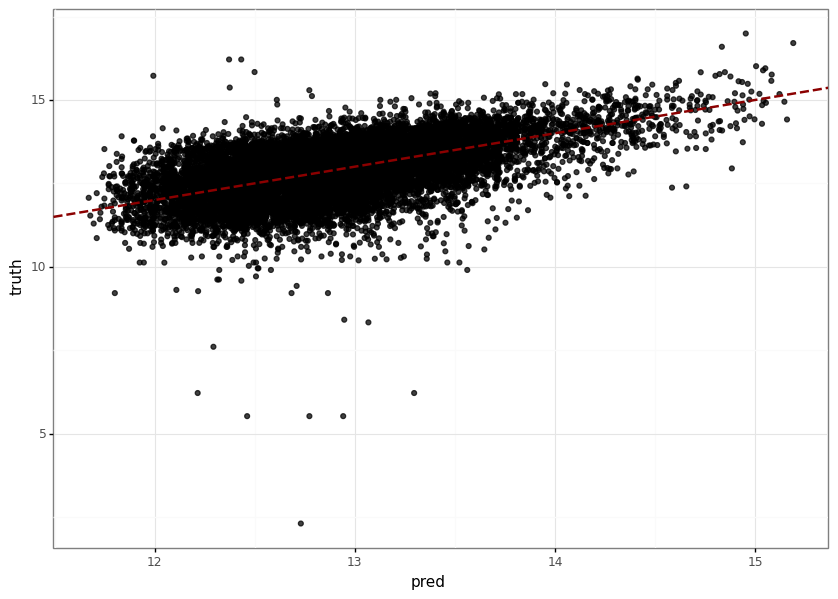

<ggplot: (8765913966147)>

In [57]:
#showing predicted vs true values and regression line plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)

The best fitting parameter was the KNeighborsRegressor with the number of parameters as 30. The mean squared error when using the test data was 0.50 and an R^2 of 0.32. Model could be improved as the graph shows there are some strange outliers in the predicted value being too high for some of the values. In addition, the selected variables can be changed. 